# Constructive Neural Networks Tutorial
This tutorial will demonstrate an approach to implementing a constructive algorithm in PyTorch.
Modifying a tutorial provided in the 60-minute Blitz on the PyTorch website: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

In [ ]:
params = list(net.parameters())
print(len(params))
print(params[2].size())  # conv2's .weight

In [8]:
from TLDatasetLoaders import MNISTDataset

m_data = MNISTDataset()

print(vars(m_data.trainloader))
print(m_data.trainset[0])

{'dataset': Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: MNIST
    Transforms (if any): Compose(
                             Pad(padding=2, fill=0, padding_mode=constant)
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None, 'batch_size': 4, 'num_workers': 0, 'collate_fn': <function default_collate at 0x0000020C191E9F28>, 'pin_memory': False, 'drop_last': False, 'timeout': 0, 'worker_init_fn': None, 'sampler': <torch.utils.data.sampler.RandomSampler object at 0x0000020C1D4E2940>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x0000020C1D4E2A20>, '_DataLoader__initialized': True}
(tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         ...,
       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


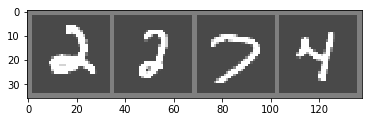

tensor(2) tensor(2) tensor(7) tensor(4)


In [3]:
import torchvision
from TLDatasetLoaders import imshow

# get some random training images
dataiter = iter(m_data.testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [ ]:
# optimiser
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(m_data.trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
dataiter = iter(m_data.testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in m_data.testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in m_data.testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

In [177]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConstructiveNet(nn.Module):

    def __init__(self):
        super(ConstructiveNet, self).__init__()
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.ModuleList([nn.Conv2d(1,3,5), nn.Conv2d(1,3,5)]))
        self.layers.append(nn.ModuleList([nn.Conv2d(6,16,5)]))
        self.layers.append(nn.ModuleList([nn.Linear(16 * 5 * 5, 120)]))
        self.layers.append(nn.ModuleList([nn.Linear(120, 10)]))
        self.layers.append(nn.ModuleList([nn.Linear(10, 10)]))

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(torch.cat([net_m(x) for net_m in iter(self.layers[0])],1)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.layers[1][0](x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.layers[2][0](x))
        x = F.relu(self.layers[3][0](x))
        x = self.layers[4][0](x)
        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def append_kaiming_uniform(self, weight_parameter, new_channels, 
                                a=0, mode='fan_in', 
                                nonlinearity='leaky_relu'):
        size = [m for m in weight_parameter.size()]
        size_append = [m for m in weight_parameter.size()]
        size[1] += new_channels 
        size_append[1] = new_channels
        
        # calculate fan_in or fan_out
        if len(size)<2:
            raise ValueError("Fan in and fan out can not be computed for tensor with fewer than 2 dimensions")
        fan_x = size[1] if mode=='fan_in' else size[0]
        if len(size)>2:
            #num_input_fmaps = size[1]
            #num_output_fmaps = size[0]
            #receptive_field_size = tensor[0][0].numel()
            fan_x *= weight_parameter[0][0].numel()
        gain = torch.nn.init.calculate_gain(nonlinearity, a)
        std = gain / math.sqrt(fan_x)
        bound = math.sqrt(3.0) * std
        
        weight_tensor_append = torch.empty(size_append, requires_grad=True)
        with torch.no_grad():
            weight_tensor_append.data.uniform_(-bound,bound)
        return torch.cat([weight_parameter.data, weight_tensor_append],1)
    
    def new_in_channels(self, nmod, new_channels):
        nmod_size = nmod.weight.size()
        nmod.in_channels += new_channels
        nmod.weight.data = self.append_kaiming_uniform(nmod.weight, new_channels)
    
    # append a new nn.Module (m) to the network layer (layer)
    def append_layer_module(self, layer, m):
        if layer < len(self.layers):
            self.layers[layer].append(m)
            if layer < len(self.layers)-1:
                for nmod in iter(self.layers[layer+1]):
                    self.new_in_channels(nmod, m.out_channels)

constructive_net = ConstructiveNet()
print(constructive_net)

ConstructiveNet(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
      (1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
    )
    (1): ModuleList(
      (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    )
    (2): ModuleList(
      (0): Linear(in_features=400, out_features=120, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=120, out_features=10, bias=True)
    )
    (4): ModuleList(
      (0): Linear(in_features=10, out_features=10, bias=True)
    )
  )
)


In [178]:
#net_input = torch.randn(1,1,32,32)

#constructive_net.layers[0][1].weight
#torch.cat([constructive_net.layers[0][i](net_input) for i in enumerate(constructive_net.layers[0])])
#F.relu(constructive_net.layers[0][0](torch.randn(1,1,32,32)))

#torch.cat([net_m(net_input) for nnn in iter(constructive_net.layers[0])],1).size()

#import matplotlib.pyplot as plt 
#plt.hist(constructive_net.layers[1][0].weight.data.flatten(),25)
#plt.hist((torch.randn((1,3000)))/15,25)

# things to change in a conv module following a layer that increases size:
#  - self.in_channels
#  - self.weight

#print(len(constructive_net.layers))
#print(constructive_net.layers[0][0].weight.size()) #out_channels
#print(torch.zeros((3,1,3)))
#print(constructive_net.layers[0][0].weight)
#t_new = constructive_net.layers[0][0].weight
#t_new[0,0,0,0] = 1

#new_channels = 2
#w_size = constructive_net.layers[0][0].weight.size()
#w_size = [m for m in constructive_net.layers[0][0].weight.size()]

#w_size[0] = new_channels
#w_new = torch.zeros(w_size, requires_grad=True)

#reproduce kaiming_uniform_
#receptive_field_size = constructive_net.layers[0][0].weight[0][0].numel()

#print(receptive_field_size)

#print(constructive_net.layers[0][0].in_channels)

#print(constructive_net.layers[1][0].weight)
#print(constructive_net.layers[1][0].weight.data)

print(constructive_net.layers[1][0].weight.size())
constructive_net.append_layer_module(0, nn.Conv2d(1,3,5))
print(constructive_net)
print(constructive_net.layers[1][0].weight.size())

torch.Size([16, 6, 5, 5])
ConstructiveNet(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
      (1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
      (2): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
    )
    (1): ModuleList(
      (0): Conv2d(9, 16, kernel_size=(5, 5), stride=(1, 1))
    )
    (2): ModuleList(
      (0): Linear(in_features=400, out_features=120, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=120, out_features=10, bias=True)
    )
    (4): ModuleList(
      (0): Linear(in_features=10, out_features=10, bias=True)
    )
  )
)
torch.Size([16, 9, 5, 5])


In [179]:
# optimiser

import torch.optim as optim

cn_criterion = nn.CrossEntropyLoss()
cn_optimizer = optim.SGD(constructive_net.parameters(), lr=0.001, momentum=0.9)

In [180]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(m_data.trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        cn_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = constructive_net(inputs)
        loss = cn_criterion(outputs, labels)
        loss.backward()
        cn_optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.722
[1,  4000] loss: 0.192
[1,  6000] loss: 0.152
[1,  8000] loss: 0.125
[1, 10000] loss: 0.094
[1, 12000] loss: 0.096
[1, 14000] loss: 0.076
[2,  2000] loss: 0.074
[2,  4000] loss: 0.065
[2,  6000] loss: 0.057
[2,  8000] loss: 0.058
[2, 10000] loss: 0.059
[2, 12000] loss: 0.053
[2, 14000] loss: 0.051
Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


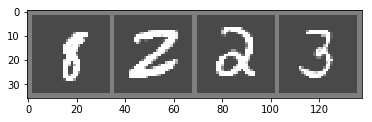

GroundTruth:  tensor(8) tensor(2) tensor(2) tensor(3)


In [181]:
dataiter = iter(m_data.testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

In [182]:
outputs = constructive_net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

Predicted:  tensor(8) tensor(2) tensor(2) tensor(3)


In [183]:
correct = 0
total = 0
with torch.no_grad():
    for data in m_data.testloader:
        images, labels = data
        outputs = constructive_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [184]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98.72 %


In [186]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in m_data.testloader:
        images, labels = data
        outputs = constructive_net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [187]:
for i in range(10):
    print('Accuracy of %4s : %6d / %4d :   %.2f %%' % (
        i, class_correct[i], class_total[i], 100 * class_correct[i] / class_total[i]))

Accuracy of    0 :    970 /  980 :   98.98 %
Accuracy of    1 :   1125 / 1135 :   99.12 %
Accuracy of    2 :   1019 / 1032 :   98.74 %
Accuracy of    3 :   1006 / 1010 :   99.60 %
Accuracy of    4 :    968 /  982 :   98.57 %
Accuracy of    5 :    880 /  892 :   98.65 %
Accuracy of    6 :    951 /  958 :   99.27 %
Accuracy of    7 :   1014 / 1028 :   98.64 %
Accuracy of    8 :    958 /  974 :   98.36 %
Accuracy of    9 :    981 / 1009 :   97.22 %
